<a href="https://colab.research.google.com/github/snehahs03/medical-image-analysis/blob/main/Vgg16model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
%cd drive

/content/drive


In [29]:
%cd MyDrive

/content/drive/MyDrive


In [30]:
%cd medical-image-analysis

/content/drive/My Drive/medical-image-analysis


In [2]:
!git clone https://github.com/snehahs03/medical-image-analysis.git

fatal: destination path 'medical-image-analysis' already exists and is not an empty directory.


In [3]:
import json
import math
import os
import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from tqdm import tqdm
from sklearn import metrics
from collections import Counter
import itertools
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, Lambda, Dense, Flatten
from keras.preprocessing import image
from glob import glob

In [4]:
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

In [5]:
eczema_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Eczema Photos", 224))
melanoma_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_train = np.array(Dataset_loader("/content/medical-image-analysis/train/Psoriasis pictures Lichen Planus and related diseases",224))
eczema_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Eczema Photos",224))
melonoma_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Melanoma Skin Cancer Nevi and Moles",224))
psoriasis_test = np.array(Dataset_loader("/content/medical-image-analysis/test/Psoriasis pictures Lichen Planus and related diseases", 224))


100%|██████████| 352/352 [00:02<00:00, 158.32it/s]


In [6]:
#labelling 
eczema_train_label = np.full(len(eczema_train),0)
melonoma_train_label = np.full(len(melanoma_train),1)
psoriasis_train_label = np.full(len(psoriasis_train),2)
eczema_test_label = np.full(len(eczema_test),0)
melonoma_test_label = np.full(len(melonoma_test),1)
psoriasis_test_label = np.full(len(psoriasis_test),2)

In [7]:
X_train = np.concatenate((eczema_train, melanoma_train, psoriasis_train), axis=0)
Y_train = np.concatenate((eczema_train_label, melonoma_train_label, psoriasis_train_label), axis=0)
X_test = np.concatenate((eczema_test, melonoma_test, psoriasis_test), axis=0)
Y_test = np.concatenate((eczema_test_label, melonoma_test_label, psoriasis_test_label), axis = 0)
print(Y_test.shape)
print(X_test.shape)

(777,)
(777, 224, 224, 3)


In [8]:
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

Y_train = to_categorical(Y_train, num_classes= 3)
Y_test = to_categorical(Y_test, num_classes= 3)

#train and evaluation split
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.3, 
    random_state=5
)

In [9]:
X_train.shape, Y_train.shape

((2172, 224, 224, 3), (2172, 3))

In [10]:
X_val.shape, Y_val.shape

((931, 224, 224, 3), (931, 3))

In [11]:
X_test.shape, Y_test.shape

((777, 224, 224, 3), (777, 3))

In [12]:
#load in pretrained model
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [13]:
#adding output layer
top_model = vgg.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(4096, activation='relu')(top_model)
top_model = Dense(1072, activation='relu')(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(3, activation='softmax')(top_model)

In [14]:
#create a model object
model3 = Model(inputs=vgg.input, outputs=output_layer)
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [15]:
#Feature extraction
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')
val_datagen.fit(X_val)


In [16]:
batch_size = 64
epochs = 10
history3 = model3.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size))


Epoch 1/10
33/33 [==============================] - 95s 1s/step - loss: 13.1375 - accuracy: 0.4676 - val_loss: 1.4582 - val_accuracy: 0.5513
Epoch 2/10
33/33 [==============================] - 29s 876ms/step - loss: 1.7409 - accuracy: 0.5596 - val_loss: 1.1577 - val_accuracy: 0.5759
Epoch 3/10
33/33 [==============================] - 29s 870ms/step - loss: 1.1127 - accuracy: 0.6093 - val_loss: 1.0920 - val_accuracy: 0.5469
Epoch 4/10
33/33 [==============================] - 29s 873ms/step - loss: 0.8988 - accuracy: 0.6259 - val_loss: 0.8021 - val_accuracy: 0.6138
Epoch 5/10
33/33 [==============================] - 29s 870ms/step - loss: 0.7714 - accuracy: 0.6488 - val_loss: 0.8456 - val_accuracy: 0.6250
Epoch 6/10
33/33 [==============================] - 29s 866ms/step - loss: 0.7558 - accuracy: 0.6621 - val_loss: 0.8266 - val_accuracy: 0.6027
Epoch 7/10
33/33 [==============================] - 29s 870ms/step - loss: 0.7315 - accuracy: 0.6794 - val_loss: 0.8682 - val_accuracy: 0.6027
E

In [18]:
#Fine-Tuning 
for layer in model3.layers[16:]:
    layer.trainable = True

In [19]:
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model3.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [20]:
batch_size = 64
epochs = 30
history3 = model3.fit(train_datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, Y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[learning_rate_reduction])

Epoch 1/30
33/33 [==============================] - 33s 903ms/step - loss: 0.7725 - acc: 0.6483 - val_loss: 0.8863 - val_acc: 0.5938
Epoch 2/30
33/33 [==============================] - 29s 881ms/step - loss: 0.7260 - acc: 0.6832 - val_loss: 0.7534 - val_acc: 0.6674
Epoch 3/30
33/33 [==============================] - 29s 880ms/step - loss: 0.6251 - acc: 0.7180 - val_loss: 0.7413 - val_acc: 0.6875
Epoch 4/30
33/33 [==============================] - 29s 885ms/step - loss: 0.5914 - acc: 0.7507 - val_loss: 0.7686 - val_acc: 0.6585
Epoch 5/30
33/33 [==============================] - 29s 882ms/step - loss: 0.5604 - acc: 0.7550 - val_loss: 0.8023 - val_acc: 0.6830
Epoch 6/30
33/33 [==============================] - 29s 885ms/step - loss: 0.4962 - acc: 0.7901 - val_loss: 0.7008 - val_acc: 0.6964
Epoch 7/30
33/33 [==============================] - 29s 888ms/step - loss: 0.4598 - acc: 0.8119 - val_loss: 0.7451 - val_acc: 0.7210
Epoch 8/30
33/33 [==============================] - 29s 887ms/step - 

In [21]:
loss_val, acc_val = model3.evaluate(X_val, Y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

30/30 [==============================] - 6s 172ms/step - loss: 1.1131 - acc: 0.7723
Validation: accuracy = 0.772288  ;  loss_v = 1.113061


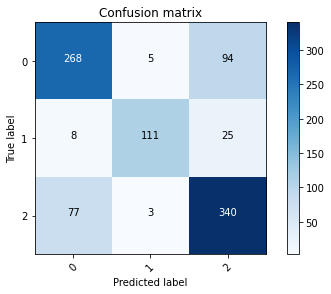

In [22]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred = model3.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(3))

TESTING1


In [23]:
loss_test, acc_test = model3.evaluate(X_test, Y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

25/25 [==============================] - 6s 234ms/step - loss: 0.9434 - acc: 0.8031
Test: accuracy = 0.803089  ;  loss = 0.943450


Text(0.5, 1.0, 'Training and validation loss')

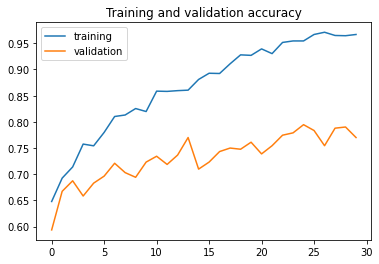

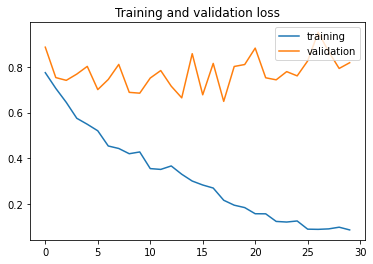

In [26]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history3.history['acc']
val_acc = history3.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history3.history['loss']
val_loss = history3.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

In [31]:
model3.save("VGG16model3.h5")